# Test

In [35]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

import neurite as ne
from utils import losses

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Args():
    def __init__(self):        
        self.batch_size = 1
        self.smooth_weight = 0.01 
        self.seg_weight = 0 
args = Args()


class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)
    
    
with open('/HDD/vxm-models/structured-data/filtered_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)
with open('/HDD/vxm-models/structured-data/filtered_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)
    
images, labels = [], []
for ind, img in pre_images.items():
    images.append(torch.from_numpy(img))
for ind, img in pre_labels.items():
    labels.append(torch.from_numpy(img))
       
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()
for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()
    

def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=workers)
    return dataloader
dataloader = get_dataloader(images, labels, args.batch_size)
dice_loss_func = losses.Dice().loss

In [36]:
import torch
import torch.nn as nn

from models.conv_lstm import ConvLSTM
from models.unet import Unet
from utils.spatial_transform import SpatialTransformer


class REG_RNN(nn.Module):
    def __init__(self, image_size):
        super(REG_RNN, self).__init__()
        self.image_size = image_size
        self.ndims = len(image_size)

        enc_nf = [16, 32, 32, 32]
        dec_nf = [32, 32, 32, 32, 32, 16, 16]
        self.unet = Unet(inshape=image_size, infeats=2, nb_features=[enc_nf, dec_nf])

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % self.ndims)
        self.flow = Conv(self.unet.final_nf, self.ndims, kernel_size=3, padding=1)

        self.rnn = ConvLSTM(input_dim=2, hidden_dim=2, kernel_size=(3, 3), num_layers=1, batch_first=False)
        self.spatial_transformer = SpatialTransformer(size=image_size)

    def forward(self, images, labels=None):

        # shape of imgs/lbs: (seq_size, bs, 1, W, H)
        # shape of unet_out: (seq_size - 1, bs, 2, W, H)
        
        st_pack = zip(images[:-1] + images[1:], images[1:] + images[:-1])
        
        unet_out = torch.cat(
            [self.flow(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0)
             for src, trg in st_pack], dim=0)
        

        rnn_out, last_states = self.rnn(unet_out)
        h, c = last_states[0]

        # shape of flows: (seq_size - 1, bs, 2, W, H)
        flows = rnn_out[0].permute(1, 0, 2, 3, 4)

        # shape of moved_images = (seq_size - 1, bs, 1, W, H)
        moved_images = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(images[:-1] + images[1:], flows[:])], dim=0)

        if labels is not None:
            moved_labels = torch.cat(
                [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(labels[:-1] + labels[1:], flows[:])], dim=0)
            return [moved_images, moved_labels, flows]
        else:
            return [moved_images, flows]

In [37]:
model = REG_RNN(dataloader.dataset.image_size)
model.to('cuda')
model.eval()

REG_RNN(
  (unet): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stri

In [38]:
base = '/HDD/kian/saved-models/'
model_folder = '30/'
snap_shot = '0400'
PATH = f'{base}{model_folder}{snap_shot}.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

mean: 0.9071883 , std: 0.010060351


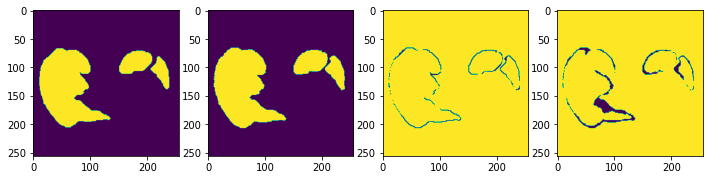

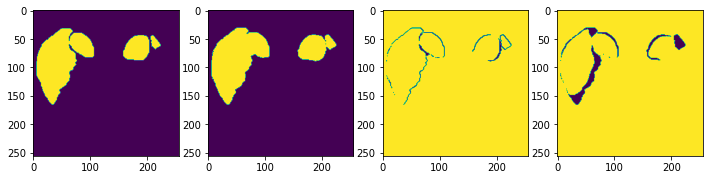

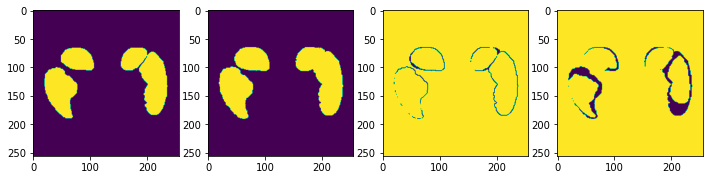

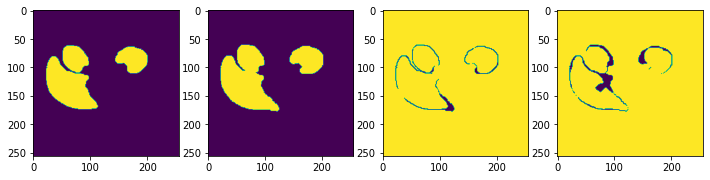

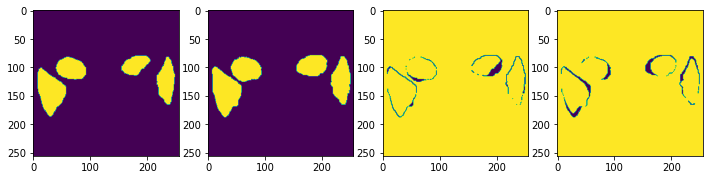

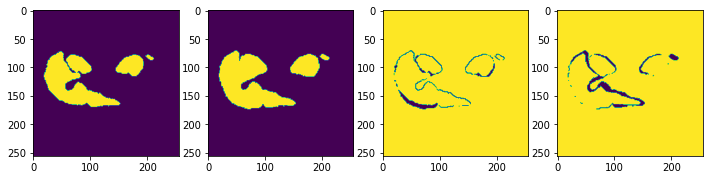

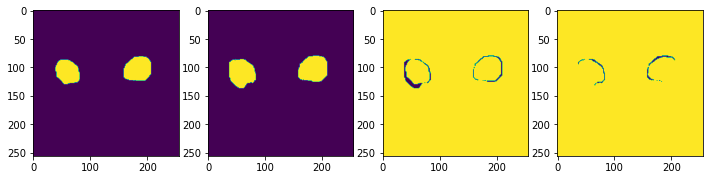

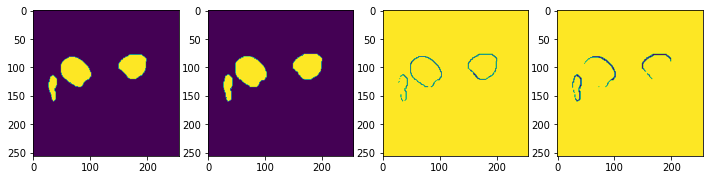

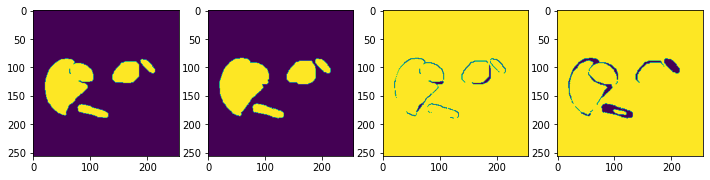

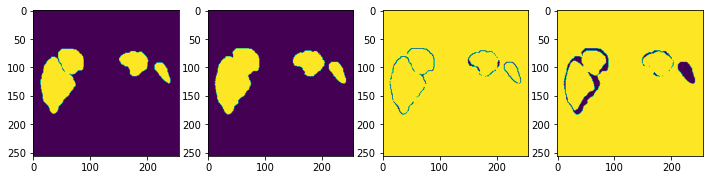

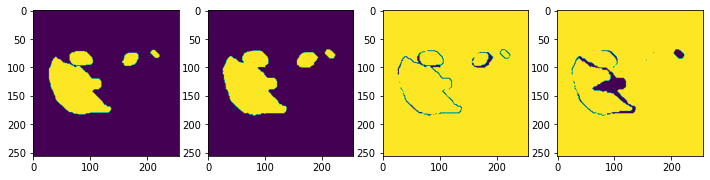

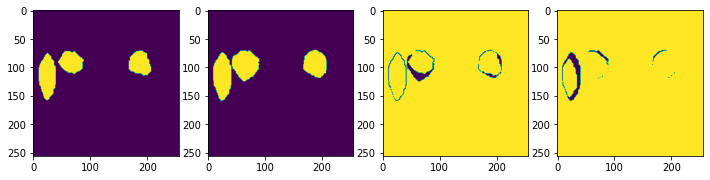

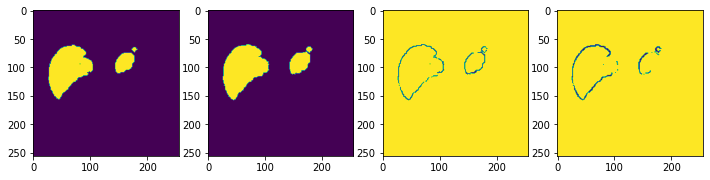

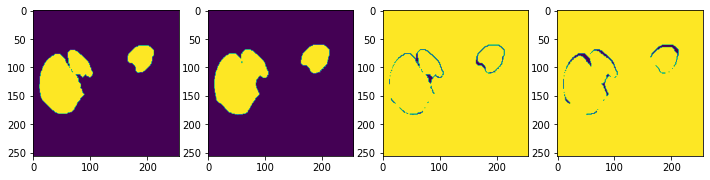

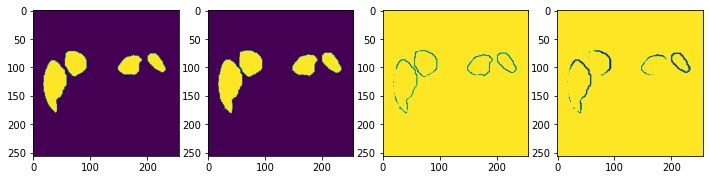

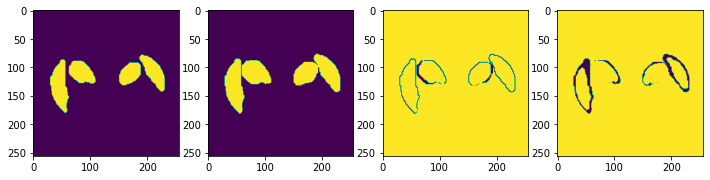

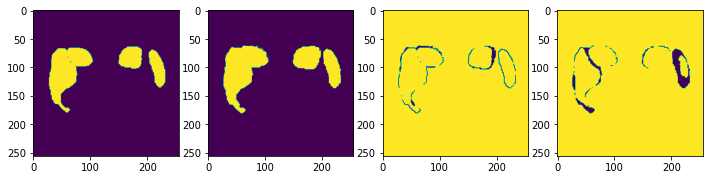

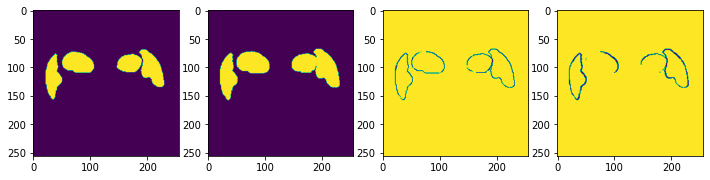

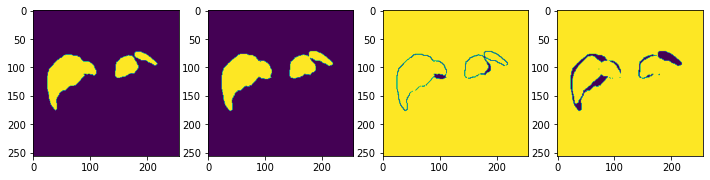

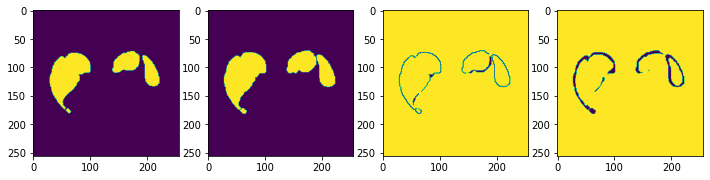

In [39]:
dice_score = []
for d_idx, data in enumerate(dataloader):
#     if d_idx > 0:
#         break
        
    imgs, lbs = data
    bs = imgs.shape[0]

    # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

    # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
    # shape of flows: (seq_size - 1, bs, 2, W, H)
    with torch.no_grad():
        moved_imgs, moved_lbs, flows = model(imgs, lbs)

#         fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
#         ax1.imshow(u_out[10].squeeze(0)[0].detach().cpu())

        
        for i in range(bs):
            zero = torch.zeros_like(lbs[1:, i]).to('cuda')
            one = torch.ones_like(lbs[1:, i]).to('cuda')
            fixed_lbs_ = torch.where(lbs[1:, i] > 0, one, zero)
            moved_lbs_ = torch.where(moved_lbs[:, i] > 0, one, zero)
            lbs = torch.where(lbs[:-1, i] > 0, one, zero)

            # exclude padding
            labeled = []
            for k in range(fixed_lbs_.shape[0]):
                if fixed_lbs_[k].max() != 0.0 and moved_lbs_[k].max() != 0.0:
                    labeled.append(k)
            fixed_lbs_ = fixed_lbs_[labeled]
            moved_lbs_ = moved_lbs_[labeled]          
            dd = (-dice_loss_func(fixed_lbs_, moved_lbs_)).detach().cpu().numpy()
            
#             print('moving: ', np.abs(lbs.squeeze(0).squeeze(0).cpu() - moved_lbs_.squeeze(0).cpu()).sum())
#             print('fixed:  ', np.abs(fixed_lbs_.squeeze(0).squeeze(0).cpu() - moved_lbs_.squeeze(0).cpu()).sum())
#             print()
            
            if d_idx % 1 == 0:
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 12))
                ax1.imshow(fixed_lbs_[10].squeeze(0).cpu())
                ax2.imshow(moved_lbs_[10].squeeze(0).cpu())
                ax3.imshow(fixed_lbs_[10].squeeze(0).cpu() - moved_lbs_[10].squeeze(0).cpu())
                ax4.imshow(lbs[10].squeeze(0).squeeze(0).cpu() - moved_lbs_[10].squeeze(0).cpu())
#                 print(dd, end=' ')

            dice_score.append(dd)

print('mean:', np.mean(dice_score), ', std:', np.std(dice_score))

In [40]:
import json
tmet = json.load(open(f'{base}{model_folder}/train_metrics.json'))

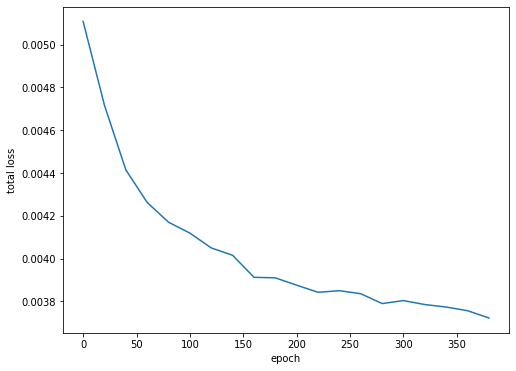

In [41]:
eps, loss = [], []
for m in tmet:
    eps.append(m.get('epoch'))
    loss.append(m.get('epoch_loss_sim'))
plt.figure(figsize=(8, 6))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
# plt.title('model trained with SGD (lr: 0.001  momentum: 0.9)');